# Experimental Design
***
## Contrast Choice

Import the necessary packages and code for this application of the framework.

In [1]:
%matplotlib inline

import numpy as np
import sys

# Add to system path to access experimental design code.
sys.path.append('../experimental-design')

from refnx.reflect import SLD, Slab
from refnx.analysis import Parameter

from optimise import Optimiser
from structures import BaseBilayer
from design import contrast_choice_single, contrast_choice_double

# Reduce size of plots for the notebook.
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 100

Next, define the structure that we want to find the optimal contrasts for. The code below defines a model describing a symmetric bilayer. It inherits from the BaseBilayer class which contains the methods for calculating the Fisher information.

In [2]:
class SymmetricBilayer(BaseBilayer):
    def __init__(self):
        self.name = 'symmetric_bilayer'

        self.si_sld      = 2.073
        self.sio2_sld    = 3.41
        self.dmpc_hg_vol = 320.9
        self.dmpc_tg_vol = 783.3
        self.dmpc_hg_sl  = 6.41e-4
        self.dmpc_tg_sl  = -3.08e-4
        self.water_vol   = 30.4

        # Calculate the SLD of the tailgroup.
        self.tg_sld = (self.dmpc_tg_sl / self.dmpc_tg_vol) * 1e6

        # Define the parameters of the model.
        self.si_rough      = Parameter(2,     'Si/SiO2 Roughness',      (1,8))
        self.sio2_thick    = Parameter(14.7,  'SiO2 Thickness',         (5,20))
        self.sio2_rough    = Parameter(2,     'SiO2/DMPC Roughness',    (1,8))
        self.sio2_solv     = Parameter(0.245, 'SiO2 Hydration',         (0,1))
        self.dmpc_apm      = Parameter(49.9,  'DMPC Area Per Molecule', (30,60))
        self.bilayer_rough = Parameter(6.57,  'Bilayer Roughness',      (1,8))
        self.bilayer_solv  = Parameter(0.074, 'Bilayer Hydration',      (0,1))
        self.hg_waters     = Parameter(3.59,  'Headgroup Bound Waters', (0,20))

        self.parameters = [self.si_rough,
                           self.sio2_thick,
                           self.sio2_rough,
                           self.sio2_solv,
                           self.dmpc_apm,
                           self.bilayer_rough,
                           self.bilayer_solv,
                           self.hg_waters]

        # Vary all of the parameters defined above.
        for param in self.parameters:
            param.vary=True

    def _using_conditions(self, contrast_sld, underlayer=None):
        """Creates a structure representing the bilayer measured using a
           contrast of given `contrast_sld`.

        Args:
            contrast_sld (float): SLD of contrast to simulate.
            underlayer (tuple): thickness and SLD of underlayer.

        Returns:
            refnx.reflect.Structure: structure in given contrast.

        """
        # We do not need to consider underlayers for this example.
        assert underlayer is None
        
        # Calculate the SLD of the headgroup with the given contrast SLD.
        hg_sld = contrast_sld*0.27 + 1.98*0.73

        vol_hg = self.dmpc_hg_vol + self.hg_waters*self.water_vol
        hg_thick = vol_hg / self.dmpc_apm
        tg_thick = self.dmpc_tg_vol / self.dmpc_apm

        substrate = SLD(self.si_sld)
        solution  = SLD(contrast_sld)(rough=self.bilayer_rough)

        sio2     = Slab(self.sio2_thick, self.sio2_sld, self.si_rough,      vfsolv=self.sio2_solv)
        inner_hg = Slab(hg_thick,        hg_sld,        self.sio2_rough,    vfsolv=self.bilayer_solv)
        outer_hg = Slab(hg_thick,        hg_sld,        self.bilayer_rough, vfsolv=self.bilayer_solv)
        tg       = Slab(tg_thick,        self.tg_sld,   self.bilayer_rough, vfsolv=self.bilayer_solv)

        solution  = SLD(contrast_sld)(rough=self.bilayer_rough)

        return substrate | sio2 | inner_hg | tg | tg | outer_hg | solution

Define the inputs to the contrast selection code.

In [3]:
# Path to directory to save results to.
save_path = './results'

# Specify the model.
sample = SymmetricBilayer()

# Number of points and times to simulate for each angle.
angle_times = [(0.7, 70, 10), (2.3, 70, 40)] # (Angle, Points, Time)

# Contrast SLDs to consider.
contrast_range = np.linspace(-0.56, 6.36, 100)

***
### Single Contrast
We can investigate the choice of contrast SLD for single contrast choices. First assuming only D2O has been measured, then only H2O, and finally D2O and H2O.

>>> 0/100
Contrast choice with D2O: -0.56


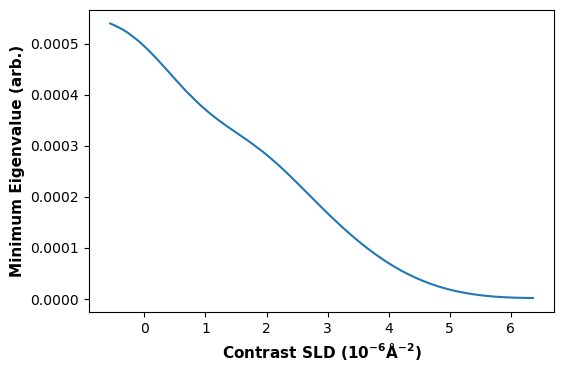

In [4]:
# Single contrast choice, assuming D2O was first measured.
contrast_1 = contrast_choice_single(sample, contrast_range, [6.36], angle_times, save_path, 'D2O')
print('Contrast choice with D2O: {}'.format(round(contrast_1, 2)))

>>> 0/100
Contrast choice with H2O: 6.36


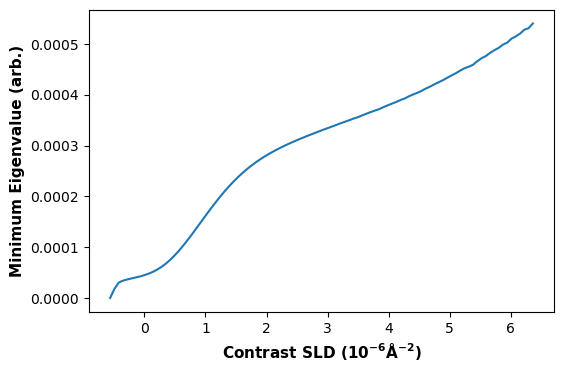

In [5]:
# Single contrast choice, assuming H2O was first measured.
contrast_2 = contrast_choice_single(sample, contrast_range, [-0.56], angle_times, save_path, 'H2O')
print('Contrast choice with H2O: {}'.format(round(contrast_2, 2)))

>>> 0/100
Contrast choice with D2O & H2O: 1.33


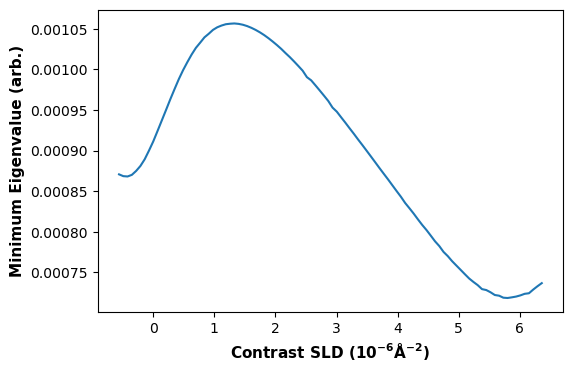

In [6]:
# Single contrast choice, assuming D2O and H2O were measured.
contrast_3 = contrast_choice_single(sample, contrast_range, [-0.56, 6.36], angle_times, save_path, 'H2O_D2O')
print('Contrast choice with D2O & H2O: {}'.format(round(contrast_3, 2)))

***
### Multiple Contrasts
We can also consider the choice of two contrasts simultaneously. In this case, we assume no prior measurement.

>>> 0/190
Contrast pair: (-0.55, 6.36)


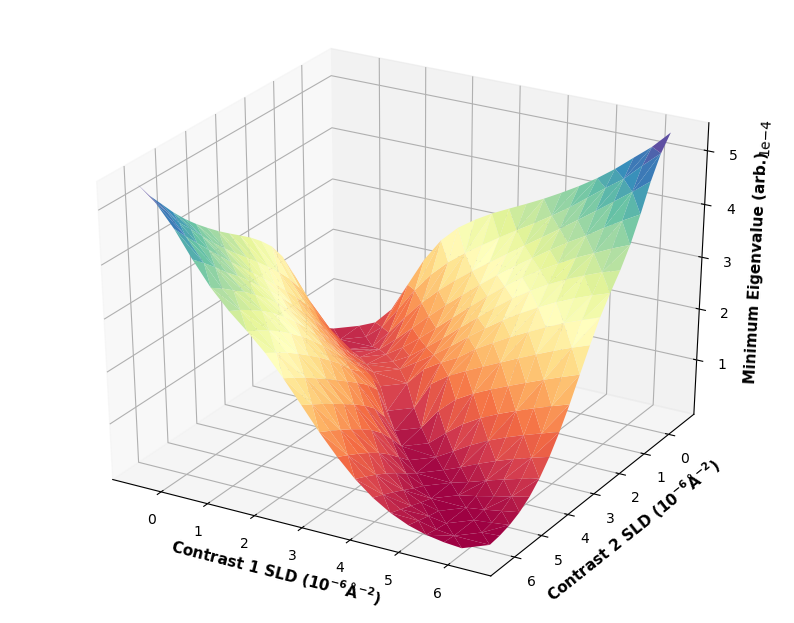

In [7]:
contrast_range = np.linspace(-0.55, 6.36, 20) # Define a smaller range.
contrast_pair = contrast_choice_double(sample, contrast_range, angle_times, save_path, reverse_xaxis=False)
print('Contrast pair: {}'.format(contrast_pair))

***
### Optimisation

As we go beyond selecting two contrasts at once, visualising the optimisation space becomes more difficult. Instead of this brute force approach, we can apply established optimisation algorithms to find the optimal solution for us. Here we apply the differential evolution algorithm to find the optimal choice of contrasts.

Due to [issues](https://docs.python.org/2.7/library/multiprocessing.html#using-a-pool-of-workers) with the multiprocessing module and interactive interpreters on Windows, the optimisation function must be in a separate file. Here we import the same bilayer sample, as defined above, from a different file to fix this issue. If running on other operating systems, this cell can be ignored. If on Windows and you wish to use the model defined in this notebook, you can set workers=1 but this will be quite slow!

In [8]:
from structures import SymmetricBilayer
sample = SymmetricBilayer()

In [9]:
optimiser = Optimiser(sample)
num_contrasts = 3
angle_times = [(0.5, 100, 55), (2.3, 100, 945)]

contrasts = optimiser.optimise_contrasts(num_contrasts, angle_times, workers=-1)
print('Contrasts: {}'.format(contrasts))

51it [02:41,  3.17s/it]

Contrasts: [ 1.30154104 -0.55648722  6.35995392]


As can be seen, the results strongly agree with our findings when considering contrasts individually.